# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 4:
**Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)**

In [2]:
from __future__ import print_function, division

import matplotlib.pylab as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

import statsmodels.api as sm

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation import train_test_split
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
#plt.rcParams['font.size'] = 20

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    


Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# read in data
## please uncomment to download data

In [3]:
# downloading data
#!curl https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/MTA_Fare.npy > MTA_Fare.npy

# loading data
mta = np.load('MTA_Fare.npy')

In [4]:
print ("MTA array shape:", mta.shape)

MTA array shape: (600, 23, 194)


**You need to create a date range to plot properly.  
After that I create a date range (for example with pd.date_range())  
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))  
all time series, each station each ride type, look like this (pretty ugly)**

In [5]:
#date = pd.date_range(start='05/19/2010', end='02/19/2014', freq='W')

In [6]:
#len(date)

In [7]:
#date

In [8]:
# creating a date range
date = pd.date_range(start='05/19/2010', periods=194, freq='W')

In [9]:
len(date)

194

In [10]:
date

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

In [11]:
# change value to floats to be able to change (-1) values to nans
mta = mta.astype(float)

# assign -1 values to nan
mta[mta == -1] = np.nan

(733915.0, 735266.0)

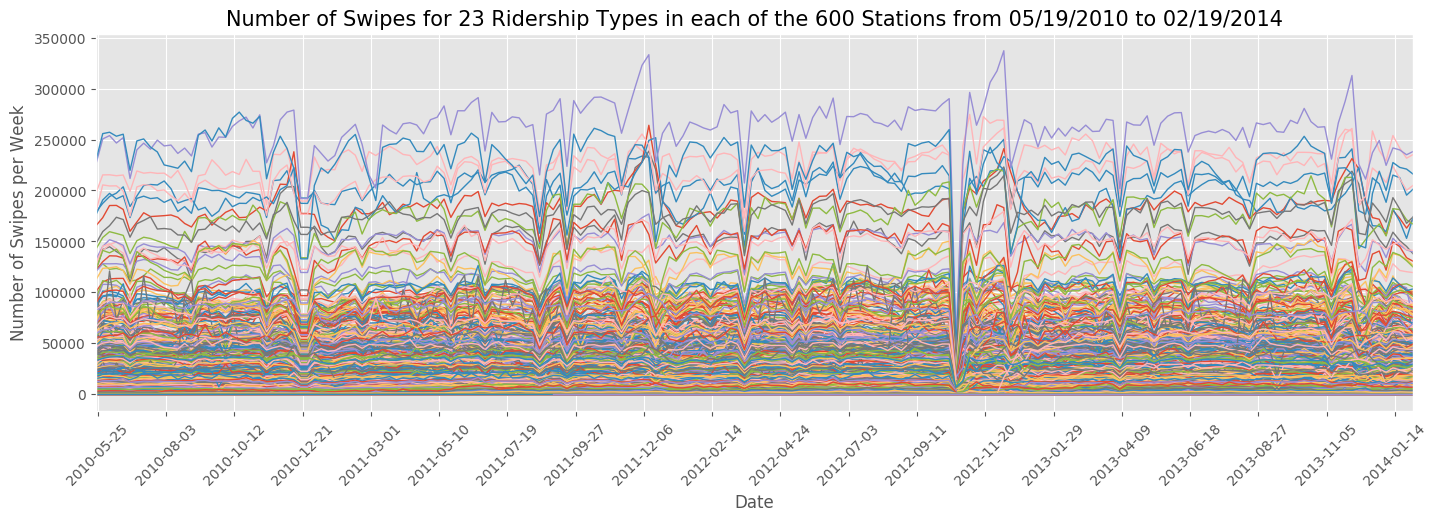

In [12]:
# choosing a plotting style fivethirtyeight or ggplot
plt.style.use('ggplot')

# plot the data in natural space
fig, ax = plt.subplots(figsize=(17,5), dpi=100)

for i in range(len(mta)):
    for ii in range(len(mta[i])):
        ax.plot(date, mta[i][ii], linewidth=1)
        
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Swipes per Week', fontsize=12)
plt.title('Number of Swipes for 23 Ridership Types in each of the 600 Stations from 05/19/2010 to 02/19/2014', fontsize=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.xlim(date[0],date[-1])

#ax.set_xticks(ax.get_xticks()[::2])

#### Figure 1: time series for all ride types and all stations in natural space

(733915.0, 735266.0)

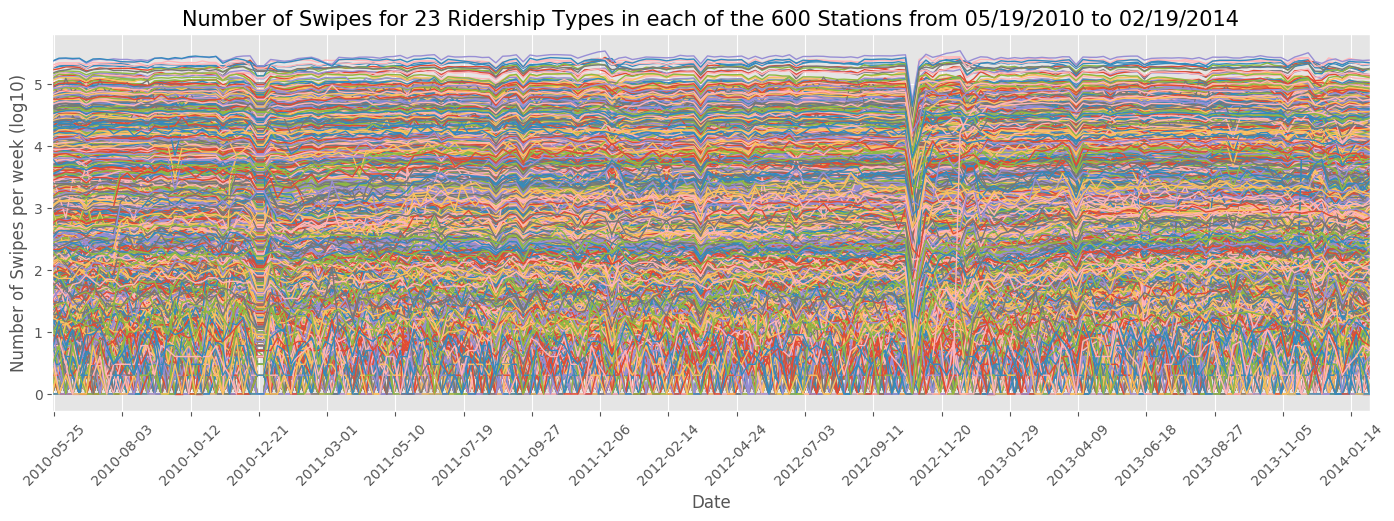

In [13]:
# then plot the  data in log space
fig, ax = plt.subplots(figsize=(17,5), dpi=100)

for i in range(len(mta)):
    for ii in range(len(mta[i])):
        ax.plot(date, np.log10(mta[i][ii]), linewidth=1)
        
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Swipes per week (log10)', fontsize=12)
plt.title('Number of Swipes for 23 Ridership Types in each of the 600 Stations from 05/19/2010 to 02/19/2014', fontsize=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.xlim(date[0],date[-1])



#### Figure 2: time series for all ride types and all stations in semi-log space

# 4. Fourier transform
np.fft.rfft() **to take the fourier transform**

and

np.fft.rfftfreq() **to create a meaningful x axis **

In [14]:
# change value to floats to be able to change (-1) values to nans
mta = mta.astype(float)

# assign -1 values to nan
mta[mta == -1] = np.nan

In [15]:
# summing along axis 1 ridership types
mta_ = np.nansum(mta, axis=1)
print ("MTA array shape summed over all ride types:", mta_.shape)

MTA array shape summed over all ride types: (600, 194)


In [16]:
mta_.shape

(600, 194)

In [17]:
N = 3 * 52 
f = np.square((np.fft.rfft(mta_, n=N).real))
f.shape

(600, 79)

In [18]:
np.fft.rfftfreq(N, 1.0)

array([ 0.        ,  0.00641026,  0.01282051,  0.01923077,  0.02564103,
        0.03205128,  0.03846154,  0.04487179,  0.05128205,  0.05769231,
        0.06410256,  0.07051282,  0.07692308,  0.08333333,  0.08974359,
        0.09615385,  0.1025641 ,  0.10897436,  0.11538462,  0.12179487,
        0.12820513,  0.13461538,  0.14102564,  0.1474359 ,  0.15384615,
        0.16025641,  0.16666667,  0.17307692,  0.17948718,  0.18589744,
        0.19230769,  0.19871795,  0.20512821,  0.21153846,  0.21794872,
        0.22435897,  0.23076923,  0.23717949,  0.24358974,  0.25      ,
        0.25641026,  0.26282051,  0.26923077,  0.27564103,  0.28205128,
        0.28846154,  0.29487179,  0.30128205,  0.30769231,  0.31410256,
        0.32051282,  0.32692308,  0.33333333,  0.33974359,  0.34615385,
        0.3525641 ,  0.35897436,  0.36538462,  0.37179487,  0.37820513,
        0.38461538,  0.39102564,  0.3974359 ,  0.40384615,  0.41025641,
        0.41666667,  0.42307692,  0.42948718,  0.43589744,  0.44

Text(0.5,1,'Swipes per Station power spectrum')

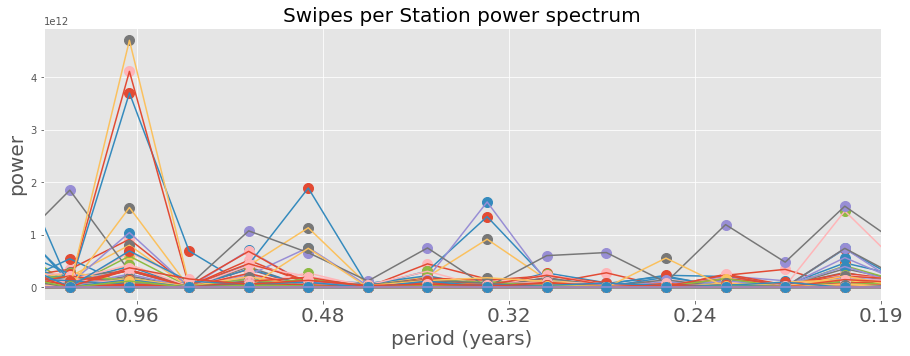

In [19]:
# plotting the fourier transform of all 600 time series
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(len(mta_)):
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[i][1:]), 'o', ms=10)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[i][1:]), '-')
    
#ax.set_xlim(0,1.0/15)
ax.set_xlim(1/100,1.0/10)

ax.set_xticklabels(["%.2f"%(1/52/tick) for tick in ax.get_xticks()], fontsize=20)
ax.set_ylabel("power", fontsize=20)
ax.set_xlabel("period (years)", fontsize=20)
ax.set_title("Swipes per Station power spectrum", fontsize=20)

**Figure 3** This is a plot of the fourier transform of the 600 stations. We removing the first entry of the FFT output array  because it is not physically interesting and it is always a very large number. By plotting the points [1:], i.e. the FFT omitting its first value, we can see what happens much better, since the high value at [0] will force the y range in the plot to be very large. We observe a peak in the plot at a period of almost one year. the next step is identifying the time series that have peaked.

In [20]:
x = np.argsort(-f[:,3])
x[:4]

array([194, 150,   0, 327])

Text(0.5,1,'Swipes per Station power spectrum')

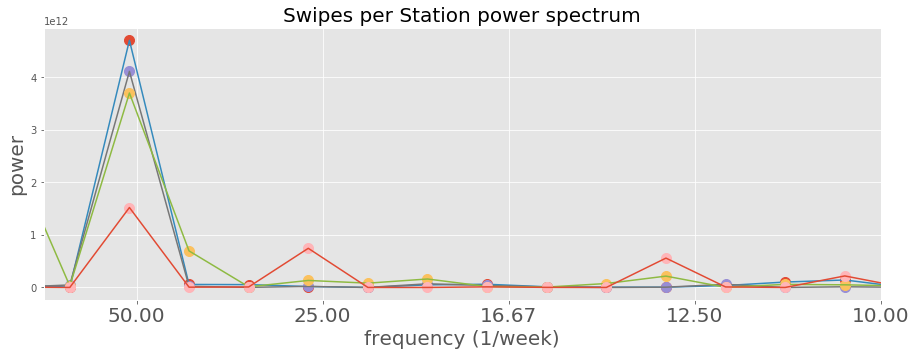

In [21]:
# plotting the highest peaks
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

for i in x[:4]:
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[i][1:]), 'o', ms=10)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[i][1:]), '-')
    
#ax.set_xlim(0,1.0/15)
ax.set_xlim(1/100,1.0/10)

ax.set_xticklabels(["%.2f"%(1/tick) for tick in ax.get_xticks()], fontsize=20)
ax.set_ylabel("power", fontsize=20)
ax.set_xlabel("frequency (1/week)", fontsize=20)
ax.set_title("Swipes per Station power spectrum", fontsize=20)

Text(0,0.5,'Number of Swipes per Week')

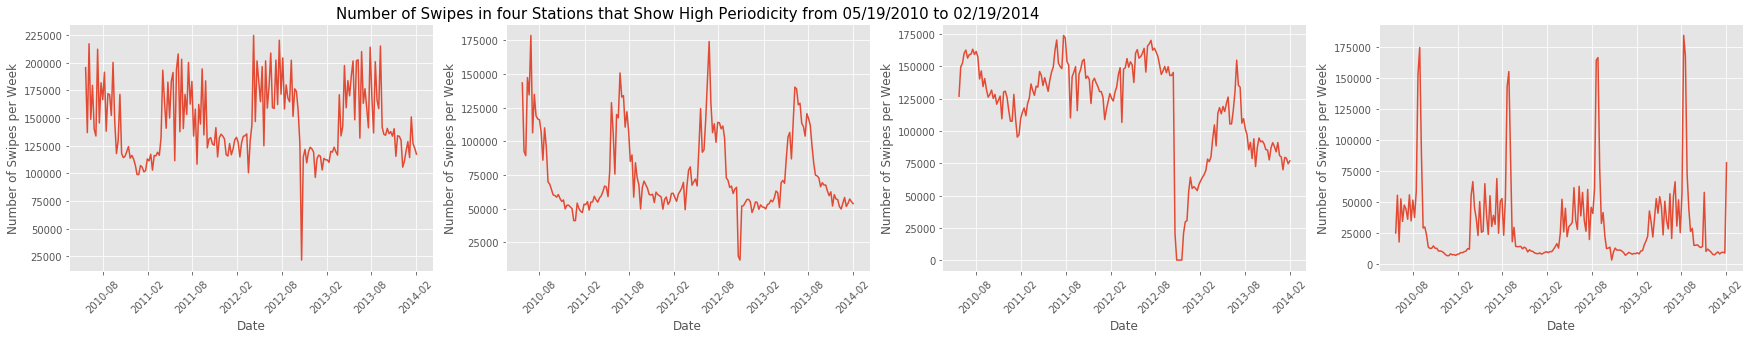

In [22]:
fig = plt.figure(figsize=(30,10))
fig.add_subplot(241)

date = pd.date_range(start='05/19/2010', periods=194, freq='W')

plt.plot(date, mta_[194])
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Number of Swipes per Week', fontsize=12)

fig.add_subplot(242)
plt.plot(date, mta_[150])
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Number of Swipes per Week', fontsize=12)
plt.title('Number of Swipes in four Stations that Show High Periodicity from 05/19/2010 to 02/19/2014', fontsize=15)

fig.add_subplot(243)
plt.plot(date, mta_[0])
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Number of Swipes per Week', fontsize=12)

fig.add_subplot(244)
plt.plot(date, mta_[327])
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Number of Swipes per Week', fontsize=12)

**Figure 5** plot of the time series that have shown high periodcity in the fourier transform. It looks like the peaks are around the end of the year starting from the end of the  summer season (August/September) in which toursits tend to visit the city which will raise the number of people using the sybway and show similar seasonality to what we are seeing here.